<a href="https://colab.research.google.com/github/qiao-hao-git/Deep-Learning-Experiment/blob/main/%E6%B7%B1%E5%BA%A6%E5%AD%A6%E4%B9%A0%E5%AE%9E%E9%AA%8C%E4%B8%80.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
import torchvision
import torchvision.transforms as transforms

In [ ]:
transforms = transforms.Compose([
    transforms.Resize((32, 32)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

train_data = torchvision.datasets.MNIST('./dataset',train=True,download=True,transform=transforms)
test_data = torchvision.datasets.MNIST('./dataset',train=False,download=True,transform=transforms)

100%|██████████| 9912422/9912422 [00:00<00:00, 139243397.13it/s]

Extracting ./dataset/MNIST/raw/train-images-idx3-ubyte.gz to ./dataset/MNIST/raw


100%|██████████| 28881/28881 [00:00<00:00, 137967760.62it/s]


Extracting ./dataset/MNIST/raw/train-labels-idx1-ubyte.gz to ./dataset/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 32215184.59it/s]

Extracting ./dataset/MNIST/raw/t10k-images-idx3-ubyte.gz to ./dataset/MNIST/raw


100%|██████████| 4542/4542 [00:00<00:00, 16310384.22it/s]


Extracting ./dataset/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./dataset/MNIST/raw



In [ ]:
print(train_data[0][0].size())
print(test_data[0][0].size())

torch.Size([1, 32, 32])
torch.Size([1, 32, 32])


In [ ]:
train_loader = torch.utils.data.DataLoader(train_data, batch_size=16, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=16, shuffle=False)

In [ ]:
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from tqdm import tqdm

In [ ]:
class Lenet(nn.Module):
  def __init__(self):
    super(Lenet,self).__init__()
    self.conv1 = nn.Sequential(
        nn.Conv2d(1, 16, 3, 1, 1),
        nn.ReLU(),
        nn.MaxPool2d(2, 2)
    )
    self.conv2 = nn.Sequential(
        nn.Conv2d(16, 32, 3, 1, 1),
        nn.ReLU(),
        nn.MaxPool2d(2, 2)
    )
    self.fc = nn.Sequential(
        nn.Linear(32*8*8, 256),
        nn.ReLU(),
        nn.Linear(256, 64),
        nn.ReLU(),
        nn.Linear(64, 10),
    )
  def forward(self, x):
    y = self.conv1(x)
    y = self.conv2(y)
    y = y.view(-1, 32*8*8)
    y = self.fc(y)
    return y

In [ ]:
lr, wd, lr_period, lr_decay, epochs = 1e-4, 1e-4, 10, 0.9, 20
model = Lenet()
if torch.cuda.is_available():
  model = model.cuda()
optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=wd)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, lr_period, lr_decay)
loss_fn = nn.CrossEntropyLoss()

In [ ]:
train_loss = []
for epoch in range(epochs):
  running_loss = 0.0

  for image, label in tqdm(train_loader, total=len(train_loader)):
    if torch.cuda.is_available():
      image = image.cuda()
      label = label.cuda()
    output = model(image)
    loss = loss_fn(output, label)
    running_loss += loss.item()
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

  scheduler.step()
  if epoch % 5 == 0:
    print(f'Epoch [{epoch + 1}/{epochs}] - Loss: {running_loss:.4f}')
  train_loss.append(running_loss)

100%|██████████| 3750/3750 [00:32<00:00, 114.68it/s]


Epoch [1/20] - Loss: 1319.6242


100%|██████████| 3750/3750 [00:29<00:00, 127.44it/s]


Epoch [6/20] - Loss: 135.3033


100%|██████████| 3750/3750 [00:26<00:00, 141.83it/s]


Epoch [11/20] - Loss: 64.0810


100%|██████████| 3750/3750 [00:25<00:00, 149.20it/s]


Epoch [16/20] - Loss: 35.9244


100%|██████████| 3750/3750 [00:25<00:00, 148.65it/s]


In [ ]:
import numpy as np
def plot_curve(y, title, xlabel, ylabel):
    x = np.arange(len(y))
    fig, ax = plt.subplots()
    ax.plot(x, y, label='Loss')
    ax.set_title(title)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.legend()
    fig.tight_layout()
    plt.show()

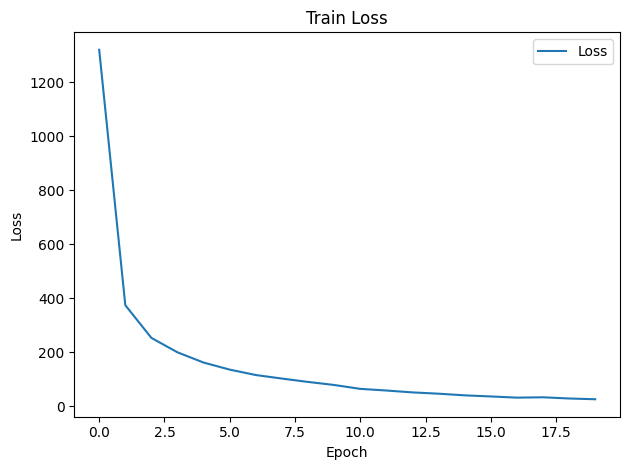

In [ ]:
plot_curve(train_loss, 'Train Loss', 'Epoch', 'Loss')

In [ ]:
model.eval()
num_correct, num_samples = 0, 0
with torch.no_grad():
  for image, label in train_loader:
    if torch.cuda.is_available():
      image = image.cuda()
      label = label.cuda()
    pred = model(image)
    _, predictions = pred.max(1)
    num_correct += (predictions==label).sum()
    num_samples += label.size(0)

  accuracy = float(num_correct/num_samples)
  print('Accuracy = '+ str(accuracy*100) + '%')

Accuracy = 99.91999864578247%


In [ ]:
model.eval()
num_correct, num_samples = 0, 0
test_loss = []
with torch.no_grad():
  for image, label in test_loader:
    if torch.cuda.is_available():
      image = image.cuda()
      label = label.cuda()
    pred = model(image)
    _, predictions = pred.max(1)
    loss = loss_fn(pred, label)
    test_loss.append(loss.item())
    num_correct += (predictions==label).sum()
    num_samples += label.size(0)

  accuracy = float(num_correct/num_samples)
  print('Accuracy = '+ str(accuracy*100) + '%')

Accuracy = 99.19999837875366%


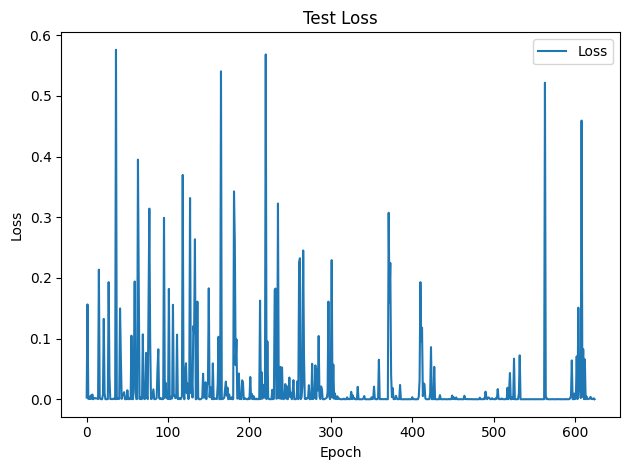

In [ ]:
plot_curve(test_loss, 'Test Loss', 'Epoch', 'Loss')